In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("./Combined Data.csv")

df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
df.isnull().sum()


Unnamed: 0    0
statement     0
status        0
dtype: int64

In [5]:
df.dropna()
df.isnull().sum()

Unnamed: 0    0
statement     0
status        0
dtype: int64

In [7]:
# Counts for each Mental Health status
df["status"].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

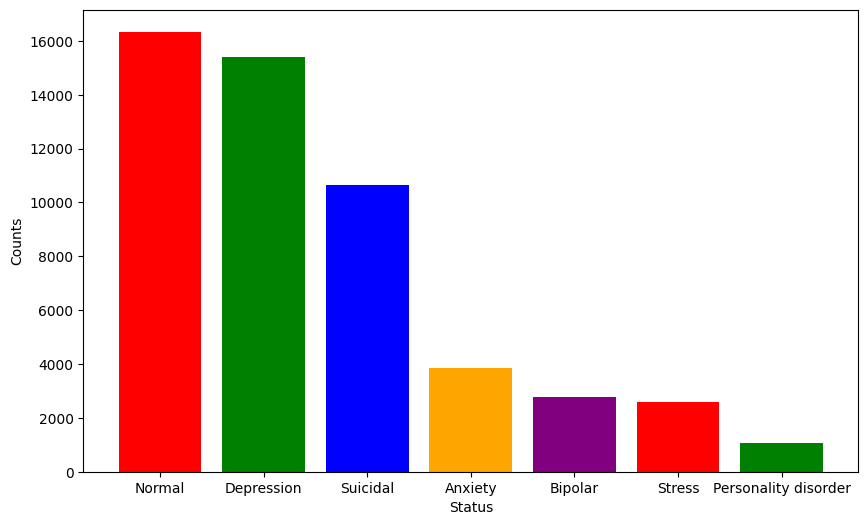

In [11]:
# Visualization of distribution of each Mental Health Status
s_count = df["status"].value_counts()
colors = ['red', 'green', 'blue', 'orange', 'purple'] 

plt.figure(figsize=(10,6))
plt.bar(s_count.index, s_count.values, color=colors[:len(s_count)])
plt.xlabel("Status")
plt.ylabel("Counts")
plt.show()